# The Price Is Right

作成者: n-ken  
発表日: 2017年6月9日

## モデルの定式化

### 確率変数の確認

$$
\begin{eqnarray}
 & X_{true} \sim \mathcal{N}(\mu_{true}, \sigma_{true}^2)\tag{1}\\
 & X_1 \sim \mathcal{N}(\mu_1, \sigma_1^2)\tag{2}\\
 & X_2 \sim \mathcal{N}(\mu_2, \sigma_2^2)\tag{3}\\
 & X \sim \mathcal{N}(X_1 + X_2, 3000^2)\tag{4}
\end{eqnarray}
$$

### 定式化

予想価格$X_1, X_2$をパラメーターと考える($(2), (3)$)。それぞれ上記の確率分布にしたがう。また、尤度関数は$X$のしたがう確率分布となる($(4)$)。よって、ベイズの定理により事後分布は以下のように表せる。

$$
P(X_1, X_2\mid X) \propto P(X \mid X_1, X_2)P(X_1, X_2) = P(X \mid X_1, X_2)P(X_1)P(X_2)\tag{5}
$$

本来は、観測値は確定的で所与のものである。しかし、ここでは観測値$X_{true}$は確率分布にしたがっていると考える($(1)$)。よって、$(5)$式は以下のように書き換えることができる。

$$
P(X_1, X_2, X_{true}\mid X = X_{true}) \propto P(X \mid X_1, X_2)P(X_1)P(X_2)P(X_{true})I(X = X_{true})\tag{6}
$$

ここで、$I(X)$は、$X$が真の値は1、それ以外は0をとる閾値関数である。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pymc3 as pm
import theano.tensor as tt
from theano import shared

## 実装の理解

オリジナルのソースコードを参考に、このモデルで何を行なっているのかを紐解いていく。PyMC3のソースコードの方が可読性が高いため、そちらをベースに検討を行う。(筆者がPyMC3を使っていることも理由)

```python
with pm.Model() as model:
    true_price = pm.Normal("true_price", mu=mu_prior, sd=std_prior)
    
    prize_1 = pm.Normal("first_prize", mu=data_mu[0], sd=data_std[0])
    prize_2 = pm.Normal("second_prize", mu=data_mu[1], sd=data_std[1])
    price_estimate = prize_1 + prize_2
    
    # 以下の2行が解説なし
    logp = pm.Normal.dist(mu=price_estimate, sd=(3e3)).logp(true_price)
    error = pm.Potential("error", logp)
    

    trace = pm.sample(50000, step=pm.Metropolis())
    burned_trace = trace[10000:]
```

### 確率分布の作成(クラスメソッド) 

- Stochastic変数としてインスタンス化しなくても、各種メソッドを呼び出せるようになっている。
- モデルに確率変数として割り当てたくない(その必要がない)時に使用する？

In [2]:
with pm.Model() as model:
    # norm1 = pm.Normal("norm1", mu=0, sd=1)
    norm1 = pm.Normal.dist(mu=0, sd=1)

In [3]:
print(norm1.random(), norm1.random())

[-0.07760765] [-0.32725338]


mean: 0.003413(+-1.017)


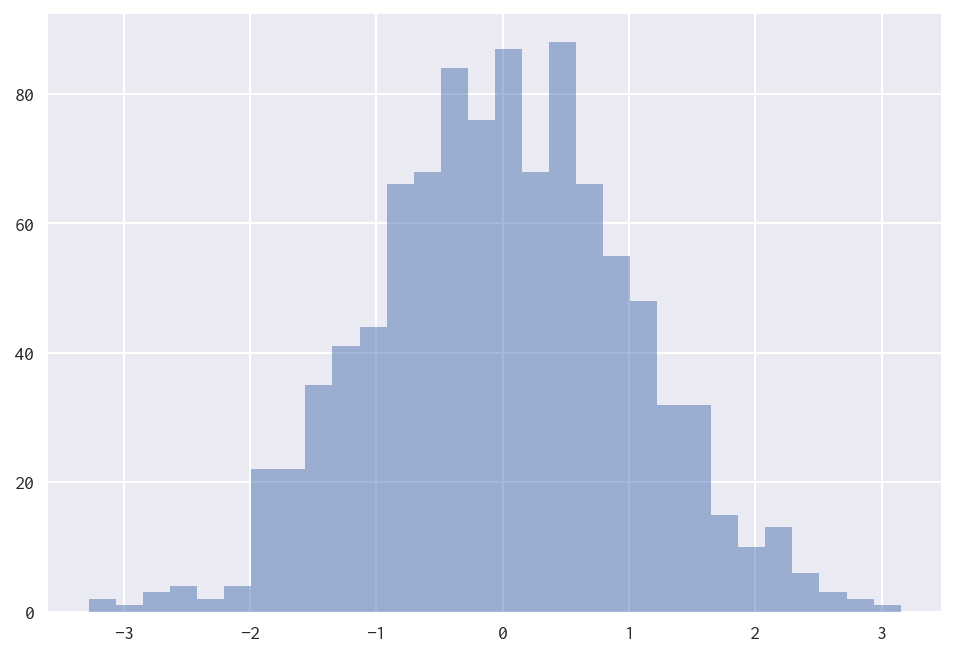

In [4]:
x1 = norm1.random(size=1000)
plt.hist(x1, bins=30, alpha=0.5);
print("mean: {:3f}(+-{:.3f})".format(x1.mean(), x1.std()))

### ``logp()``とは

- 引数にスカラーを与えた場合、観測値とみなして対数尤度を返す。
- 確率変数インスタンスを与えた場合も、実は同じ挙動をする。(内部的に保有している値を観測値として対数尤度を返す)

#### 引数にスカラーを与えた場合

In [5]:
with pm.Model() as model2:
    norm2 = pm.Normal.dist(mu=0, sd=1)
    norm22 = pm.Normal.dist(mu=-2, sd=2)

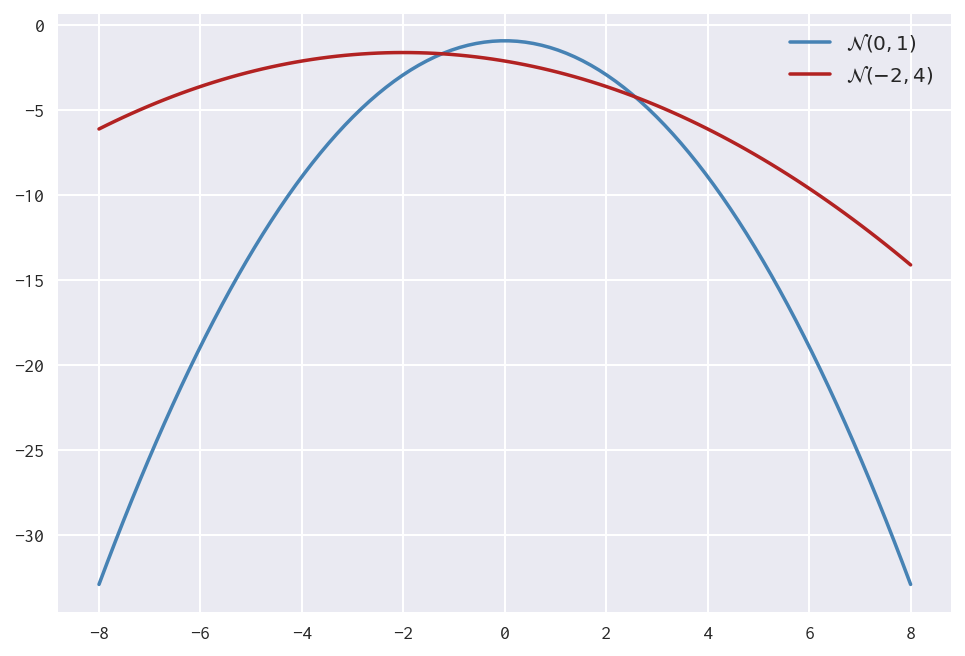

In [6]:
x = np.linspace(-8, 8, 100)
y = norm2.logp(x).tag.test_value
y2 = norm22.logp(x).tag.test_value

plt.plot(x, y, label="$\mathcal{N}(0, 1)$", color="steelblue")
plt.plot(x, y2, label="$\mathcal{N}(-2, 4)$", color="firebrick")
plt.legend()

#### 引数に確率変数を与えた場合

In [7]:
with pm.Model() as model3:
    norm1 = pm.Normal("norm1", mu=5, sd=1)
    norm2 = pm.Normal.dist(mu=0, sd=1)

In [8]:
print("norm1.tag.test_value", norm1.tag.test_value)
print("norm2.logp(norm1.tag.test_value).tag.test_value", norm2.logp(norm1.tag.test_value).tag.test_value)
print("")
print("scipy.stats.normとの比較: ", np.log(stats.norm.pdf(norm1.tag.test_value, 0, 1)))

norm1.tag.test_value 5.0
norm2.logp(norm1.tag.test_value).tag.test_value -13.418938533204672

scipy.stats.normとの比較:  -13.4189385332


In [9]:
with model3:
    logp1 = norm2.logp(norm1)

In [10]:
logp1.tag.test_value

array(-13.418938533204672)

In [11]:
norm1.tag.test_value = 1.0
norm2.logp(norm1.tag.test_value).tag.test_value

array(-1.4189385332046727)

In [12]:
with model3:
    logp2 = norm2.logp(norm1)

In [13]:
logp2.tag.test_value

array(-1.4189385332046727)

### ``pm.Potential``とは

PyMC3のドキュメントを探しても、``pm.Potential``についての説明は記載がなかった。そのため、PyMC2の[ドキュメント](http://pymc-devs.github.io/pymc/modelbuilding.html#the-potential-class)および``pm.Potential``のdocstringを参考にする。モデルに尤度を追加するための方法らしい。

In [14]:
pm.Potential??

## モデルの実装

$X_{true}$が観測値として使用されているかを確認するため、``true_price``の``shape``引数を変更して、事後分布を確認する。  
観測値として扱われているならば、``shape``の値が大きいほど真の価格と合計賞品価格の事後分布は、真の価格の事前分布に近くはずである。

In [15]:
data_mu = [3e3, 12e3]

data_std =  [5e2, 3e3] 

mu_prior = 35e3
std_prior =  75e2

with pm.Model() as price_is_right1:
    # 真の価格の事前分布
    true_price = pm.Normal("true_price", mu=mu_prior, sd=std_prior)
    
    # 各賞品価格の事前分布
    prize_1 = pm.Normal("prize_1", mu=data_mu[0], sd=data_std[0])
    prize_2 = pm.Normal("prize_2", mu=data_mu[1], sd=data_std[1])
    
    # 合計賞品価格
    total_price = pm.Deterministic("total_price", prize_1 + prize_2)
    
    # 合計賞品価格の分布
    price_estimate = pm.Normal("price_estimate", mu=total_price, sd=3e3)
    
    # 対数尤度を計算し、モデルに追加
    logp = pm.Normal.dist(mu=total_price, sd=3e3).logp(true_price)
    error = pm.Potential("error", logp)
    
    # サンプリング
    trace1 = pm.sample(50000, step=pm.Metropolis())
    burned_sample1 = trace1[10000:]

100%|██████████| 50000/50000 [00:10<00:00, 4816.55it/s]


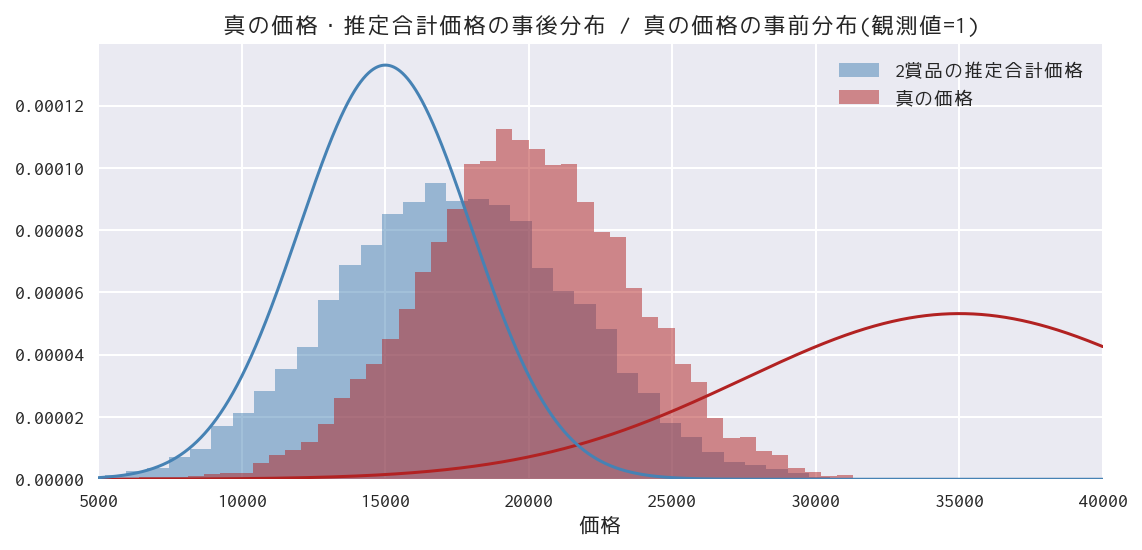

In [16]:
fig = plt.figure(figsize=(9, 4))
plt.hist(burned_sample1['price_estimate'], alpha=0.5, bins=50, normed=True, color="steelblue", label="2賞品の推定合計価格")
plt.hist(burned_sample1['true_price'], alpha=0.5, bins=50, normed=True, color="firebrick", label="真の価格")
x = np.arange(50000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), color="firebrick", lw=1.5)
plt.plot(x, stats.norm.pdf(x, 15000, 3000), color="steelblue", lw=1.5)
plt.title("真の価格・推定合計価格の事後分布 / 真の価格の事前分布(観測値=1)")
plt.xlabel("価格")
plt.xlim(5000, 40000)
plt.legend()
plt.savefig("posterior_distributions.png", transparent=True, dpi=300);

In [17]:
with pm.Model() as price_is_right2:
    # 真の価格の事前分布
    true_price = pm.Normal("true_price", mu=mu_prior, sd=std_prior, shape=100)
    
    # 各賞品価格の事前分布
    prize_1 = pm.Normal("prize_1", mu=data_mu[0], sd=data_std[0])
    prize_2 = pm.Normal("prize_2", mu=data_mu[1], sd=data_std[1])
    
    # 合計賞品価格
    total_price = pm.Deterministic("total_price", prize_1 + prize_2)
    
    # 合計賞品価格の分布
    price_estimate = pm.Normal("price_estimate", mu=total_price, sd=3e3)
    
    # 対数尤度を計算し、モデルに追加
    logp = pm.Normal.dist(mu=total_price, sd=3e3).logp(true_price)
    error = pm.Potential("error", logp)
    
    # サンプリング
    trace2 = pm.sample(50000, step=pm.Metropolis())
    burned_sample2 = trace2[10000:]

100%|██████████| 50000/50000 [00:13<00:00, 3802.21it/s]


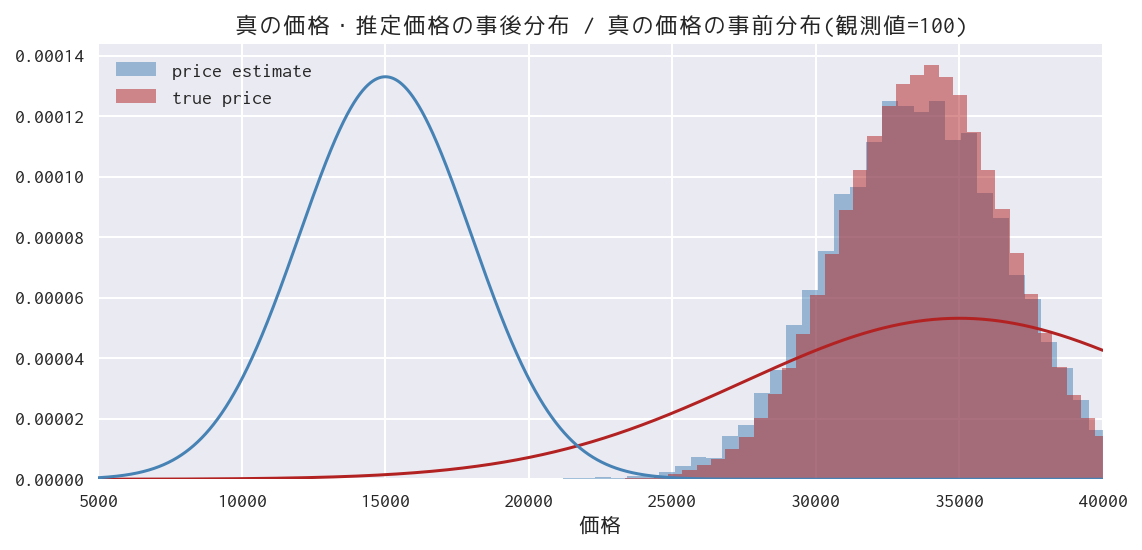

In [18]:
fig = plt.figure(figsize=(9, 4))
plt.hist(burned_sample2['price_estimate'], alpha=0.5, bins=50, normed=True, color="steelblue", label="price estimate")
plt.hist(burned_sample2['true_price'].flatten(), alpha=0.5, bins=50, normed=True, color="firebrick", label="true price")
x = np.arange(50000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), color="firebrick", lw=1.5)
plt.plot(x, stats.norm.pdf(x, 15000, 3000), color="steelblue", lw=1.5)
plt.title("真の価格・推定価格の事後分布 / 真の価格の事前分布(観測値=100)")
plt.xlabel("価格")
plt.xlim(5000, 40000)
plt.legend()
plt.savefig("posterior_distributions_n100.png", transparent=True, dpi=300);

上記の結果より、$X_{true}$が観測値として扱われて尤度計算が行われていることが確認できる。  

## 別実装

観測値として、``true_price``を渡してみると、これまでと同様の動作を示すことが確認できる。

In [19]:
with pm.Model() as the_price_is_right3:
    # 真の価格の事前分布
    true_price = pm.Normal("true_price", mu=mu_prior, sd=std_prior)
    
    # 各賞品価格の事前分布
    prize_1 = pm.Normal("prize_1", mu=data_mu[0], sd=data_std[0])
    prize_2 = pm.Normal("prize_2", mu=data_mu[1], sd=data_std[1])
    
    # 合計賞品価格
    total_price = pm.Deterministic("total_price", prize_1 + prize_2)
    
    # true priceを観測値として渡す
    y = pm.Normal("price_estimate", mu=total_price, sd=3e3, observed=true_price)
    
    trace3 = pm.sample(50000, step=pm.Metropolis())
    burned_sample3 = trace3[10000:]
    

100%|██████████| 50000/50000 [00:07<00:00, 6675.53it/s]


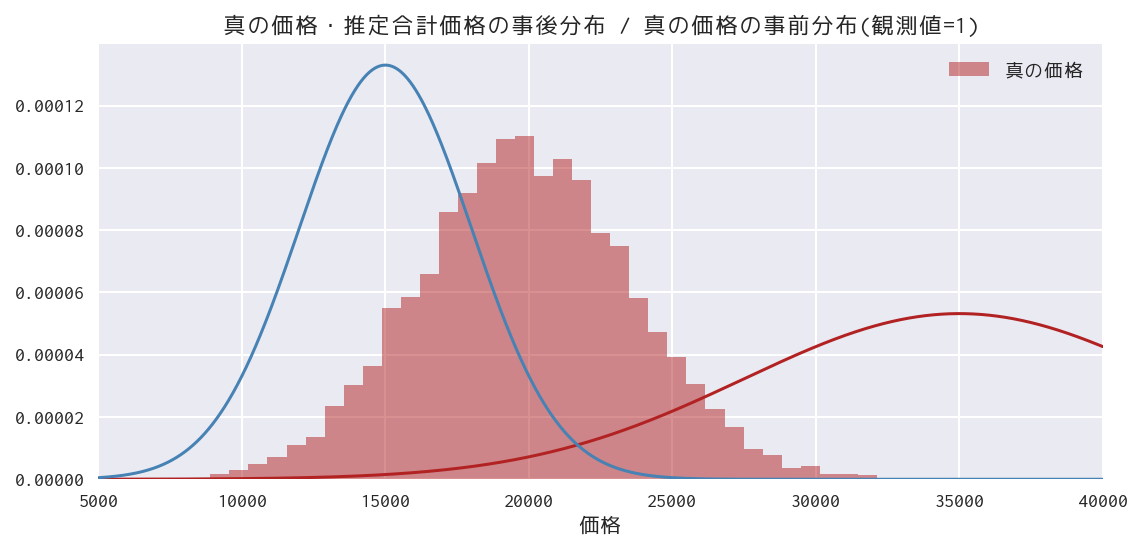

In [20]:
fig = plt.figure(figsize=(9, 4))
plt.hist(burned_sample3['true_price'], alpha=0.5, bins=50, normed=True, color="firebrick", label="真の価格")
x = np.arange(50000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), color="firebrick", lw=1.5)
plt.plot(x, stats.norm.pdf(x, 15000, 3000), color="steelblue", lw=1.5)
plt.title("真の価格・推定合計価格の事後分布 / 真の価格の事前分布(観測値=1)")
plt.xlabel("価格")
plt.xlim(5000, 40000)
plt.legend()